In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput, evaluation
import os
import global_settings
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))

In [8]:
result = results.ResultSample.load_from_file(
    os.path.join(global_settings.PATH_RESULTS, "1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz")
    #os.path.join(global_settings.PATH_PAPER_RESULTS, "5ad94859f97bf1eb1b3c7dee83ec9a5c.tar.gz")
    #os.path.join(global_settings.PATH_PAPER_RESULTS, "813959bae30f18fe9269faf06f9a2f9c.tar.gz")
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()

In [9]:
print(result.dataset.shape)

(150, 2)


In [10]:
print(result.indices_train)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


In [11]:
print(result.indices_test)

[]


# qualitative

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


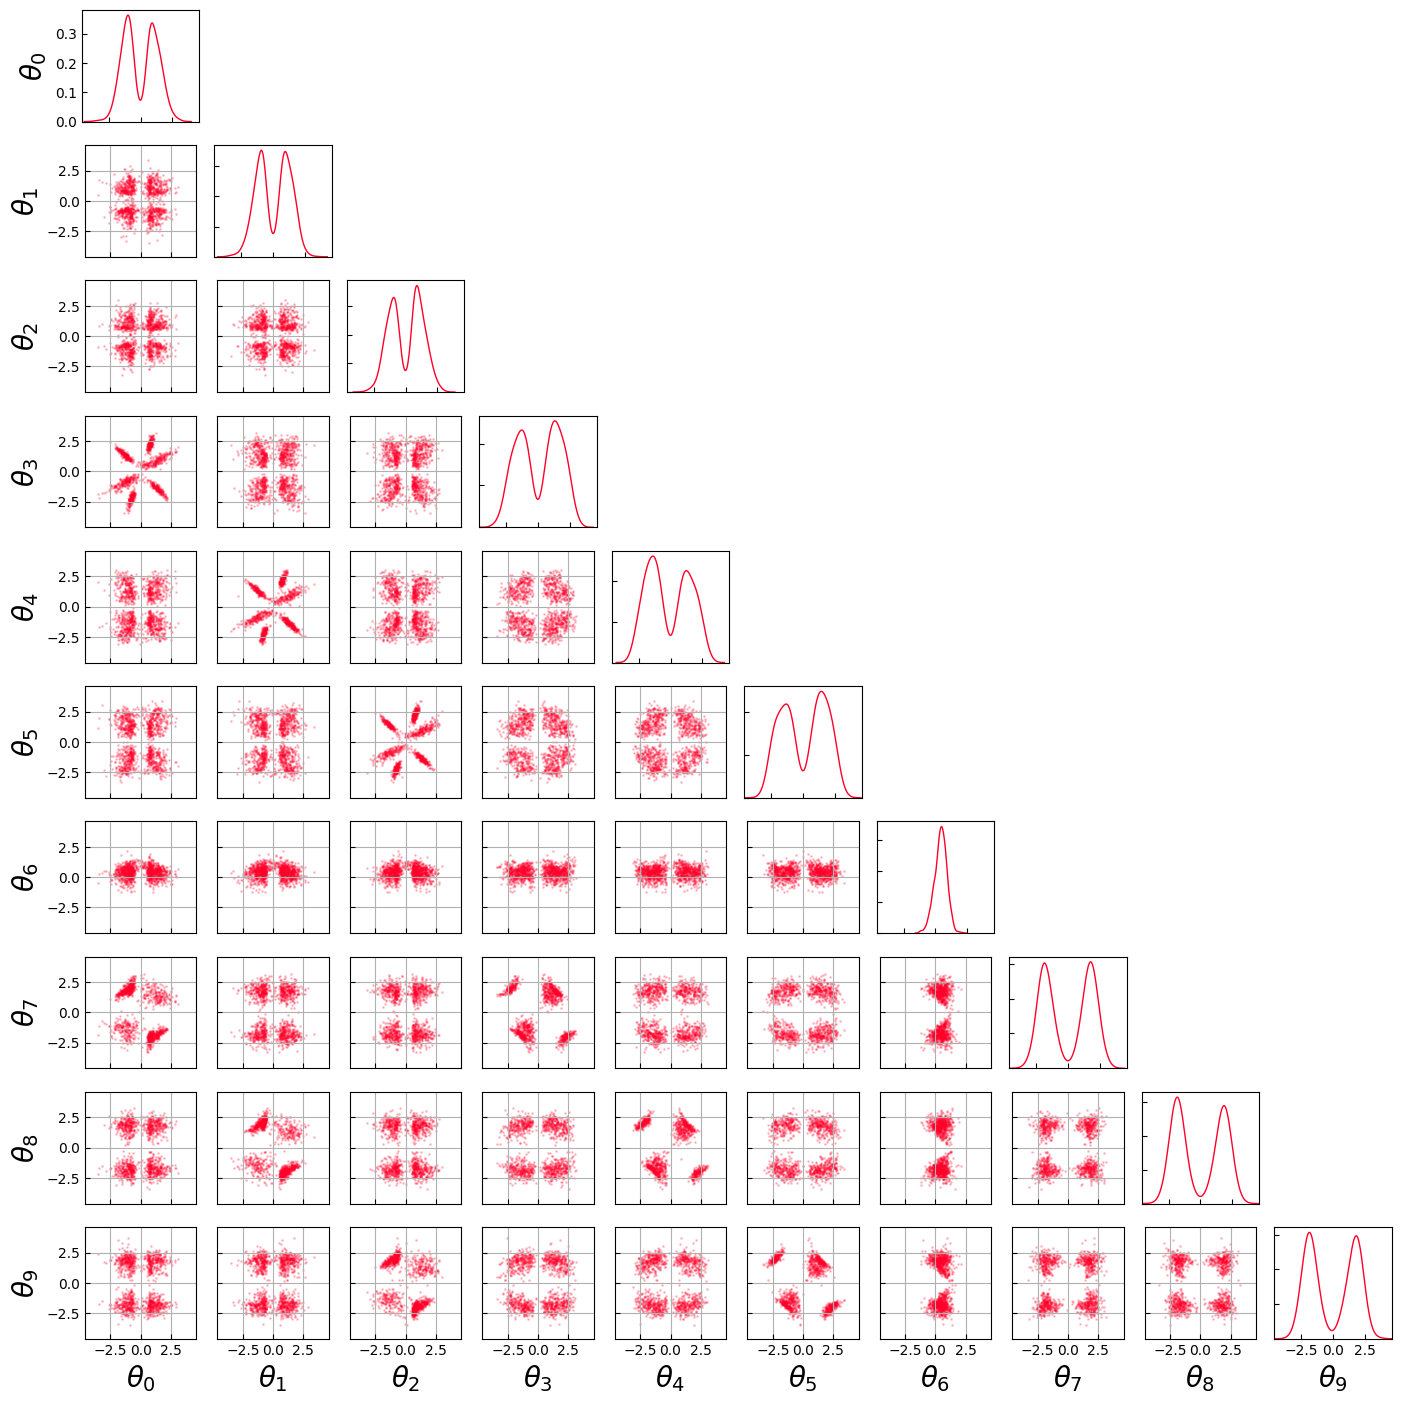

In [12]:
import matplotlib
rng_key, rng_key_ = jax.random.split(rng_key)

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[result.samples["parameters"]]
)

0.3929227


100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


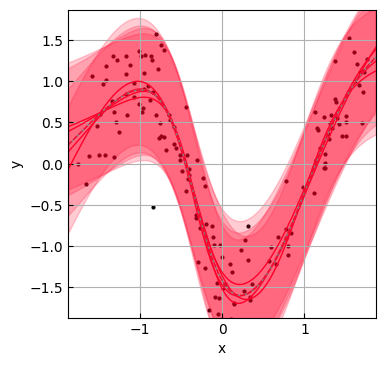

In [13]:
print(result.samples["std"].mean())
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=1.0,
            aleatoric=True
        )
    ),
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[result.samples["parameters"][:4]],
    std=result.samples["std"].mean(),
    feature=0
)

# quantitative

In [ ]:
"""
for a prediction - what do i have to do:
* i have to calculate p(y|x, D) which is density of gaussian mixtures, then maximize it?

for nll, i just compute the likelihood
"""
